# Introduction

Prepare a prototype of a machine learning model for Zyfra. The company develops efficiency solutions for heavy industry. The model should predict the amount of gold recovered from gold ore. You have the data on extraction and purification. The model will help to optimize the production and eliminate unprofitable parameters.

Data is indexed with the date and time of acquisition (date feature). Parameters that are next to each other in terms of time are often similar. Some parameters are not available because they were measured and/or calculated much later. That's why, some of the features that are present in the training set may be absent from the test set. The test set also doesn't contain targets. The source dataset contains the training and test sets with all the features. You have the raw data that was only downloaded from the warehouse. Before building the model, check the correctness of the data. For that, use our instructions.

# Importing Libraries & Loading Dataset(s)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor

import matplotlib.style as style
style.use('tableau-colorblind10')


In [2]:
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

In [3]:
train = pd.read_csv('/datasets/gold_recovery_train.csv')

test = pd.read_csv('/datasets/gold_recovery_test.csv')

full = pd.read_csv('/datasets/gold_recovery_full.csv')

# EDA

In [4]:
def data(df):
    print(df.head())
    print(df.isna().sum())
    print(df.info())
    print(df.describe())

In [5]:
data(train)

                  date  final.output.concentrate_ag  \
0  2016-01-15 00:00:00                     6.055403   
1  2016-01-15 01:00:00                     6.029369   
2  2016-01-15 02:00:00                     6.055926   
3  2016-01-15 03:00:00                     6.047977   
4  2016-01-15 04:00:00                     6.148599   

   final.output.concentrate_pb  final.output.concentrate_sol  \
0                     9.889648                      5.507324   
1                     9.968944                      5.257781   
2                    10.213995                      5.383759   
3                     9.977019                      4.858634   
4                    10.142511                      4.939416   

   final.output.concentrate_au  final.output.recovery  final.output.tail_ag  \
0                    42.192020              70.541216             10.411962   
1                    42.701629              69.266198             10.462676   
2                    42.657501              68.

In [6]:
data(test)

                  date  primary_cleaner.input.sulfate  \
0  2016-09-01 00:59:59                     210.800909   
1  2016-09-01 01:59:59                     215.392455   
2  2016-09-01 02:59:59                     215.259946   
3  2016-09-01 03:59:59                     215.336236   
4  2016-09-01 04:59:59                     199.099327   

   primary_cleaner.input.depressant  primary_cleaner.input.feed_size  \
0                         14.993118                         8.080000   
1                         14.987471                         8.080000   
2                         12.884934                         7.786667   
3                         12.006805                         7.640000   
4                         10.682530                         7.530000   

   primary_cleaner.input.xanthate  primary_cleaner.state.floatbank8_a_air  \
0                        1.005021                             1398.981301   
1                        0.990469                             1398.777

In [7]:
data(full)

                  date  final.output.concentrate_ag  \
0  2016-01-15 00:00:00                     6.055403   
1  2016-01-15 01:00:00                     6.029369   
2  2016-01-15 02:00:00                     6.055926   
3  2016-01-15 03:00:00                     6.047977   
4  2016-01-15 04:00:00                     6.148599   

   final.output.concentrate_pb  final.output.concentrate_sol  \
0                     9.889648                      5.507324   
1                     9.968944                      5.257781   
2                    10.213995                      5.383759   
3                     9.977019                      4.858634   
4                    10.142511                      4.939416   

   final.output.concentrate_au  final.output.recovery  final.output.tail_ag  \
0                    42.192020              70.541216             10.411962   
1                    42.701629              69.266198             10.462676   
2                    42.657501              68.

Since the datasets are massive(ranging from 50 to 86 columns & 5000 - 25000 rows) we will deal with null values/datatype problems on a case by case basis. If it is necessary to complete a task, I will fix the errors and document.

# Checking Recovery

In [8]:
C = train["rougher.output.concentrate_au"]
F = train["rougher.input.feed_au"]
T = train["rougher.output.tail_au"]

In [9]:
train["rougher.output.recovery.calculated"] = (C * (F - T)) / (F * (C - T)) * 100

In [10]:
mae = (train["rougher.output.recovery.calculated"] - train["rougher.output.recovery"]).abs().sum() / len(train)
print("MAE", ":", mae)

MAE : 7.883623897364653e-15


We have obtained a Mean Absolute Error of <code style="background:yellow;color:black">7.883623897364653e-15.</code> This is a very small deviation which implies that the recovery is calculated correctly.



# Analyzing Features


In [11]:
train.columns.difference(test.columns)


Index(['final.output.concentrate_ag', 'final.output.concentrate_au',
       'final.output.concentrate_pb', 'final.output.concentrate_sol',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au',
       'final.output.tail_pb', 'final.output.tail_sol',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au',
       'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol',
       'rougher.calculation.au_pb_ratio',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_au',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'roughe

# Data Preprocessing  

In [13]:
train = train.dropna()
test = test.dropna()
full = full.dropna()


In [14]:
full_merge = full[["date", "rougher.output.recovery", "final.output.recovery", "rougher.output.concentrate_au", "rougher.output.concentrate_ag", "rougher.output.concentrate_pb", "rougher.output.concentrate_sol", "final.output.concentrate_au", "final.output.concentrate_ag", "final.output.concentrate_pb", "final.output.concentrate_sol"]]

In [15]:
test = test.merge(full_merge, on="date", how="left")
full_merge = full_merge.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)

In [16]:
train = train.drop("date", axis=1)
test = test.drop("date", axis=1)
full = full.drop("date", axis=1)

# Analyzing Data
Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.

In [17]:
au = full[["rougher.input.feed_au", "rougher.output.concentrate_au", "primary_cleaner.output.concentrate_au", "final.output.concentrate_au"]]
ag = full[["rougher.input.feed_ag", "rougher.output.concentrate_ag", "primary_cleaner.output.concentrate_ag", "final.output.concentrate_ag"]]
pb = full[["rougher.input.feed_pb", "rougher.output.concentrate_pb", "primary_cleaner.output.concentrate_pb", "final.output.concentrate_pb"]]

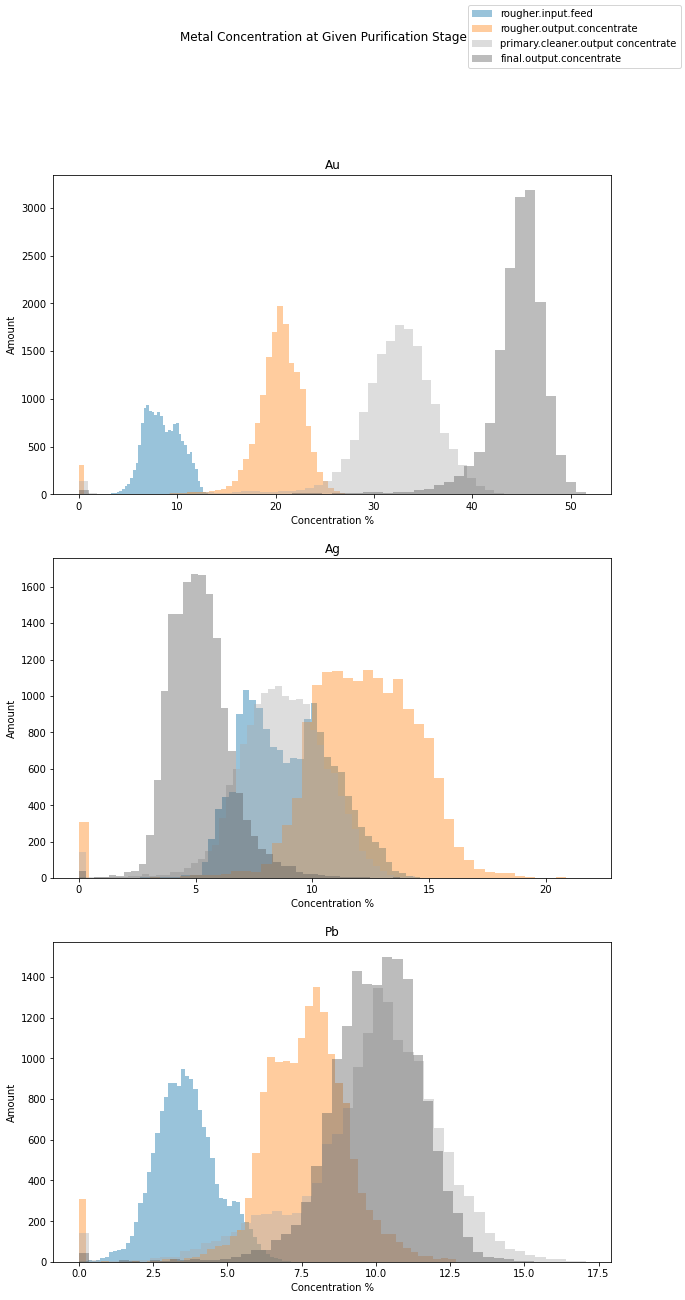

In [18]:
fig, axes = plt.subplots(3, 1, figsize=(10, 20))
for column in list(au):
    sns.distplot(au[column], ax=axes[0], kde=False)
axes[0].set(title="Au", xlabel="Concentration %", ylabel="Amount")
for column in list(ag):
    sns.distplot(ag[column], ax=axes[1], kde=False)
axes[1].set(title="Ag", xlabel="Concentration %", ylabel="Amount")
for column in list(pb):
    sns.distplot(pb[column], ax=axes[2], kde=False)
axes[2].set(title="Pb", xlabel="Concentration %", ylabel="Amount")
fig.suptitle("Metal Concentration at Given Purification Stage")
fig.legend(["rougher.input.feed", "rougher.output.concentrate", "primary.cleaner.output concentrate", "final.output.concentrate",])
fig.show()



The graph shows the level of concentration of metals(Au,Ag,Pb) at every stage. The final output of Au increased relative to its primary output. The final output concentrate of Ag decreased while Pb stayed the same.

# Comparing Feed Particle Size Distribution

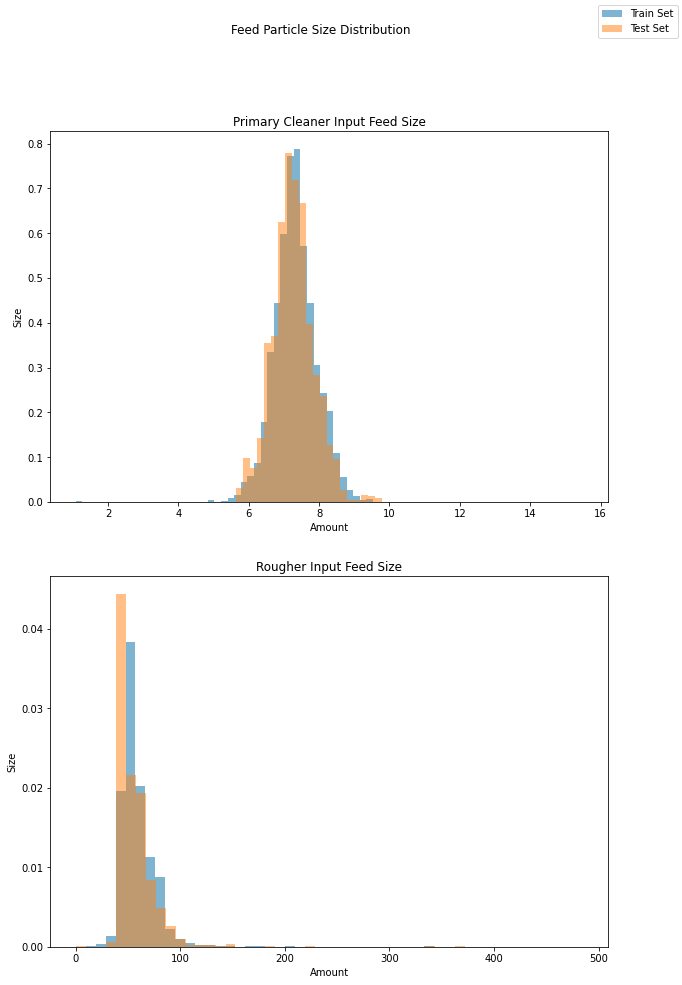

In [19]:
fig, axes = plt.subplots(2,1, figsize=(10, 15))
axes[0].hist(train["primary_cleaner.input.feed_size"], density=True, alpha=0.5, bins=50)
axes[0].hist(test["primary_cleaner.input.feed_size"], density=True, alpha=0.5, bins=50)
axes[0].set(title="Primary Cleaner Input Feed Size", xlabel="Amount", ylabel="Size")
axes[1].hist(train["rougher.input.feed_size"], density=True, alpha=0.5, bins=50)
axes[1].hist(test["rougher.input.feed_size"], density=True, alpha=0.5, bins=50)
axes[1].set(title="Rougher Input Feed Size", xlabel="Amount", ylabel="Size")
fig.suptitle("Feed Particle Size Distribution")
fig.legend(["Train Set", "Test Set"])
fig.show()

We see that the rougher input feed size for both the test and train sets are fairly equal. We see further below that the other stages the histograms are more dispersed.

# Total Concentration of all substances at different stage's

In [20]:
def raw(df):
    return df["rougher.input.feed_au"] + df["rougher.input.feed_ag"] + df["rougher.input.feed_pb"] + df["rougher.input.feed_sol"]

In [21]:
def rougher(df):
    return df["rougher.output.concentrate_au"] + df["rougher.output.concentrate_ag"] + df["rougher.output.concentrate_pb"] + df["rougher.output.concentrate_sol"]

In [22]:
def final(df):
    return df["final.output.concentrate_au"] + df["final.output.concentrate_ag"] + df["final.output.concentrate_pb"] + df["final.output.concentrate_sol"]

In [23]:
full["rougher.input.feed"] = raw(full)
full["rougher.output.concentrate"] = rougher(full)
full["final.output.concentrate"] = final(full)
total = full[["rougher.input.feed", "rougher.output.concentrate", "final.output.concentrate"]]

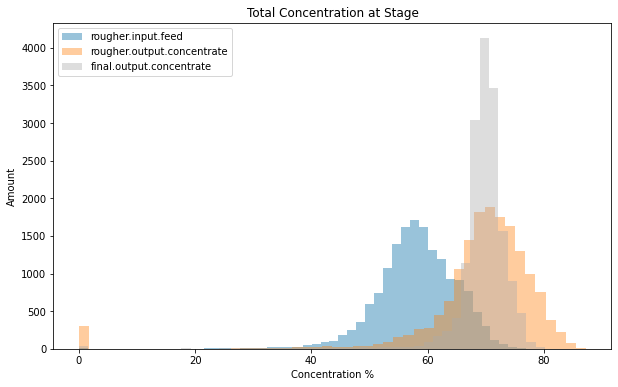

In [24]:
fig = plt.figure(figsize=(10, 6))
for column in list(total):
    sns.distplot(total[column], kde=False,)
plt.legend(list(total))
plt.title("Total Concentration at Stage")
plt.xlabel("Concentration %")
plt.ylabel("Amount")
fig.show()

We see that concentration grew from input feed to output concentrate. The final output concentation skyrocketed.

# Building The Model


In [25]:
def smape(actual, predicted): 
    return 1/len(actual) * np.sum(2*np.abs(predicted-actual)/(np.abs(actual)+np.abs(predicted))*100)

def final_smape(true, pred):
    rougher = smape(true.iloc[:, 0], pred[:,0])
    final = smape(true.iloc[:, 1], pred[:,1])
    return 0.25 * rougher + 0.75 * final

In [26]:
smape_scorer = make_scorer(final_smape, greater_is_better=False)

# Training Different Models

In [27]:
train["rougher.input.feed"] = raw(train)
train["rougher.output.concentrate"] = rougher(train)
train["final.output.concentrate"] = final(train)

In [28]:
train = train[(train["rougher.input.feed"] > 20) & (train["rougher.output.concentrate"] > 20) & (train["final.output.concentrate"] > 20)]
train = train.drop(["rougher.input.feed", "rougher.output.concentrate", "final.output.concentrate"], axis=1)

In [29]:
test["rougher.input.feed"] = raw(test)
test["rougher.output.concentrate"] = rougher(test)
test["final.output.concentrate"] = final(test)

In [30]:
test = test[(test["rougher.input.feed"] > 20) & (test["rougher.output.concentrate"] > 20) & (test["final.output.concentrate"] > 20)]
test = test.drop(["rougher.input.feed", "rougher.output.concentrate", "final.output.concentrate"], axis=1)
test = test.drop(list(full_merge.columns.values), axis=1)

In [31]:
train = train.loc[:, list(test.columns)]

In [32]:
features_train = train.drop(columns=["rougher.output.recovery", "final.output.recovery"], axis=1)
target_train = train[["rougher.output.recovery", "final.output.recovery"]]

In [33]:
feature_scaler = StandardScaler()
features_train = feature_scaler.fit_transform(features_train)

In [34]:
features_test = test.drop(columns=["rougher.output.recovery", "final.output.recovery"], axis=1)
target_test = test[["rougher.output.recovery", "final.output.recovery"]]
features_test = feature_scaler.transform(features_test)

In [35]:
def smape_value(model_name, model, features, target):
    
    scores = cross_val_score(model,
                             features,
                             target,
                             cv = 5,
                             scoring = make_scorer(final_smape, greater_is_better=False)
                            ) 
    final_score = scores.mean()

    print(f"Final sMAPE value for {model_name}: {round(final_score, 6)}")

## Linear Regression

In [36]:
model = LinearRegression()
smape_value("Linear Regression", model, features_train, target_train)

Final sMAPE value for Linear Regression: -9.957734


## Random Forest 

In [37]:
model = RandomForestRegressor(n_estimators=50,
                              max_depth=5, 
                              random_state=12345
                             )
smape_value("Random Forest Regressor", model, features_train, target_train)

Final sMAPE value for Random Forest Regressor: -9.186721


In [38]:
model = RandomForestRegressor(n_estimators=40,
                              max_depth=10, 
                              random_state=12345
                             )
smape_value("Random Forest Regressor", model, features_train, target_train)

Final sMAPE value for Random Forest Regressor: -9.395012


## Decision Tree

In [39]:
model = DecisionTreeRegressor(random_state=12345, max_depth=5)
smape_value("Decision Tree Regressor", model, features_train, target_train)

Final sMAPE value for Decision Tree Regressor: -10.811408


## Dummy Regressor

In [40]:
model = DummyRegressor(strategy="mean")
smape_value('Dummy Regressor', model,features_train, target_train)

Final sMAPE value for Dummy Regressor: -9.683012


In [42]:
model = DummyRegressor(strategy="median")
smape_value('Dummy Regressor', model,features_train, target_train)

Final sMAPE value for Dummy Regressor: -9.696396


## Best Performing Model: 

In [44]:
model = RandomForestRegressor(max_depth=5, n_estimators=50, random_state=12345) 
model.fit(features_train, target_train)
prediction = model.predict(features_test)

print('Final sMAPE value for Random Forest:', final_smape(target_test, prediction))


Final sMAPE value for Random Forest: 6.939161683762906


# Conclusion

Linear regression on the train set had a smape score of <code style="background:yellow;color:black">9.957734%</code>

Decision tree on the train set had a smape score of <code style="background:yellow;color:black">9.395012%</code>

Random forest regression on the train set has a smape score of <code style="background:yellow;color:black">9.186721%</code>

Dummy regressor had a smape score of <code style="background:yellow;color:black">9.683012%</code> for mean and for <code style="background:yellow;color:black">9.696396%</code> median.

The best performing model on the test set was the  at <code style="background:yellow;color:black">6.939161683762906%</code>

